In [1]:
from __future__ import division
from __future__ import print_function

import time
import argparse
import numpy as np

import torch
import torch.optim as optim

from utils import load_data,normalize,toy_data,norm_embed,nmi_score

import matplotlib.pyplot as plt 

In [2]:
import torch.nn as nn
import torch.nn.functional as F
from layers import GraphConvolution, InnerProduct
from utils import norm_embed
import torch

In [3]:
class GNN(nn.Module):
    
    def __init__(self, batch_size, nfeat, nhid, ndim):
        super(GNN, self).__init__()

        self.gc1 = GraphConvolution(batch_size, nfeat, nhid)
        self.embeddings = GraphConvolution(batch_size, nhid, 4*ndim)
        self.reconstructions = InnerProduct(2*ndim)

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = self.embeddings(x, adj)
        x = norm_embed(x)
        lr1, lr2 = torch.chunk(x, chunks=2, dim=2)
        mu = F.relu(self.reconstructions(lr1))
        sigma = F.relu(self.reconstructions(lr2))
        return mu,sigma
    

In [4]:
np.set_printoptions(suppress=True)
torch.set_printoptions(sci_mode=False,precision=8)

In [5]:
# Training settings
parser = argparse.ArgumentParser()
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='Disables CUDA training.')
parser.add_argument('--fastmode', action='store_true', default=False,
                    help='Validate during training pass.')
parser.add_argument('--seed', type=int, default=426, help='Random seed.')
parser.add_argument('--epochs', type=int, default=5000,
                    help='Number of epochs to train.')
parser.add_argument('--lr', type=float, default=0.01,
                    help='Initial learning rate.')
parser.add_argument('--weight_decay', type=float, default=10e-8,
                    help='Weight decay (L2 loss on parameters).')
parser.add_argument('--hidden', type=int, default=16,
                    help='Number of hidden units.')
parser.add_argument('--ndim', type=int, default=2,
                    help='Embeddings dimension.')

args = parser.parse_args(args=[])
args.cuda = not args.no_cuda and torch.cuda.is_available()

In [6]:
if 1:
    # Taxi Dataset Graph
    adj = load_data()
    #adj = load_data(daily=True)
else:
    #Toy Example Graph
    adj = toy_data()

In [11]:
def GraphNeuralNet(adj,dim):
    
    # Set the random seed
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if args.cuda:
        torch.cuda.manual_seed(args.seed)
        
    args.ndim = dim
    
    adj_norm = normalize(adj)

    adj = torch.FloatTensor(np.array(adj))
    adj_norm = torch.FloatTensor(np.array(adj_norm))

    # Model and optimizer
    model = GNN(batch_size=adj_norm.shape[0],
                nfeat=adj_norm.shape[1],
                nhid=args.hidden,
                ndim=args.ndim)

    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    model.embeddings.register_forward_hook(get_activation('embeddings'))


    optimizer = optim.Adam(model.parameters(),
                           lr=args.lr, weight_decay=args.weight_decay)



    features = torch.FloatTensor(torch.eye(adj.shape[1]))
    features = features.reshape((1,adj.shape[1],adj.shape[1]))
    features = features.repeat(adj.shape[0], 1, 1)

    if args.cuda:
        model.cuda()
        features = features.cuda()
        adj = adj.cuda()
        adj_norm = adj_norm.cuda()


    # Train model
    t_total = time.time()
    
    # loss function
    criterion = torch.nn.GaussianNLLLoss()
    
    
    # NULL Model
    mu0 = adj_norm.mean()*torch.ones(adj_norm.shape[1:])
    sigma0 = adj_norm.var()*torch.ones(adj_norm.shape[1:])
    with torch.no_grad():
        loss0 = criterion(torch.flatten(adj_norm), torch.flatten(mu0), torch.flatten(sigma0))

    for epoch in range(args.epochs):

        t = time.time()
        model.train()
        optimizer.zero_grad()
        mu,sigma = model(features, adj_norm)

        loss = criterion(torch.flatten(adj_norm), torch.flatten(mu), torch.flatten(torch.square(sigma)))
        loss.backward()
        optimizer.step()

        if epoch == 0:
            best_loss = loss
        else:
            if loss < best_loss:
                best_loss = loss

        if epoch % 1250 == 0:
            print('Epoch: {:04d}'.format(epoch + 1),
                  'loss: {:.8f}'.format(best_loss.item()),
                  'time: {:.4f}s'.format(time.time() - t))
        

    print("Optimization Finished!")
    print("Total time elapsed: {:.4f}s".format(time.time() - t_total))
    
    return adj_norm,mu,best_loss.item(),loss0


In [31]:
losses = []
nmi = []
dims = [x for x in range(1,15)]
for dim in dims:
    adj_norm,mu,loss,loss0 = GraphNeuralNet(adj=adj,dim=dim)
    losses.append(loss)
    nmi.append(nmi_score(adj_norm[0],mu.reshape(adj_norm.shape[1:]).detach()))

Epoch: 0001 loss: 45.96022797 time: 0.0040s
Epoch: 1251 loss: -4.75196838 time: 0.0000s
Epoch: 2501 loss: -4.84766150 time: 0.0000s
Epoch: 3751 loss: -4.87054062 time: 0.0000s
Optimization Finished!
Total time elapsed: 10.6141s
Epoch: 0001 loss: 45.95952225 time: 0.0040s
Epoch: 1251 loss: -5.48059559 time: 0.0040s
Epoch: 2501 loss: -5.79412270 time: 0.0000s
Epoch: 3751 loss: -5.95824146 time: 0.0000s
Optimization Finished!
Total time elapsed: 12.3936s
Epoch: 0001 loss: 45.95902252 time: 0.0040s
Epoch: 1251 loss: -5.02075529 time: 0.0030s
Epoch: 2501 loss: -5.32087755 time: 0.0030s
Epoch: 3751 loss: -5.65267706 time: 0.0030s
Optimization Finished!
Total time elapsed: 12.5550s
Epoch: 0001 loss: 45.95979309 time: 0.0030s
Epoch: 1251 loss: -5.51748466 time: 0.0030s
Epoch: 2501 loss: -5.74126911 time: 0.0030s
Epoch: 3751 loss: -5.79498863 time: 0.0030s
Optimization Finished!
Total time elapsed: 11.6724s
Epoch: 0001 loss: 45.96011353 time: 0.0032s
Epoch: 1251 loss: -5.79494286 time: 0.0030s


NMI Score dim 1 = 0.38486398105496666
NMI Score dim 2 = 0.4884528204568523
NMI Score dim 3 = 0.5125426765981764
NMI Score dim 4 = 0.7396799065338122
NMI Score dim 5 = 0.7362572411470623
NMI Score dim 6 = 0.875877389968318
NMI Score dim 7 = 0.7755459863947763
NMI Score dim 8 = 0.7568641371674953
NMI Score dim 9 = 0.7980435593482093
NMI Score dim 10 = 0.8959063864846745
NMI Score dim 11 = 0.7377317368825123
NMI Score dim 12 = 0.8852996522817232
NMI Score dim 13 = 0.8582317747078609
NMI Score dim 14 = 0.7711744890346364

 NLL0 = -4.101871490478516


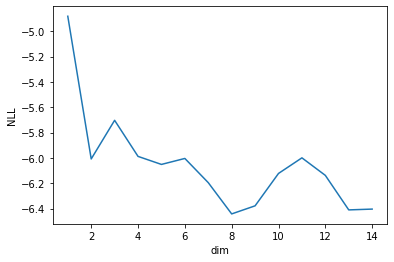

In [32]:
plt.plot(dims,losses)
plt.xlabel("dim")
plt.ylabel("NLL")
for i in dims:
    print("NMI Score dim {} = {}".format(i,nmi[i-1]))
print("\n NLL0 = {}".format(loss0))